Import packages

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import netcdf
import scipy.interpolate
from mpl_toolkits.basemap import Basemap

Declare global variables

In [20]:
# Global variables
EARTH_RADIUS = 6371e3    # meters
OMEGA = 7.292e-5         # radians per second
STANDARD_GRAVITY = 9.806 # meters per second squared

Atmosphere class

In [21]:
class Atmosphere:
    """ Contains atmospheric parameters (u speed, v speed, geopotential height
    gradient) for two time layers at a given time.

    hour -- The first layer time, a multiple of the interval between GFS files. 
    """
    def __init__(self,
                 hour,                         # First layer time in hours
                 resolution):                               

        self.layer_time = hour * 60 ** 2       # First layer time in seconds
        self.time_between_files = 3 * 60 ** 2  # Time between samples in seconds
        self.total_time = 8 * 24 * 60 ** 2     # Full trajectory time in seconds
        self.resolution = float(resolution)    # Degrees per grid square
        self.sample = np.int(self.resolution // 0.25)  # Step to sample with

        # Test that the argument is a valid hour.
        if self.layer_time > self.total_time - self.time_between_files:
            raise ValueError("Maximum value for hour argument is {}."
                           .format((self.total_time - self.time_between_files)
                                    / 60 ** 2))

        if self.layer_time % self.time_between_files != 0:
            raise ValueError("Hour argument must be a multiple of {}."
                             .format(self.time_between_files))          

        # Generate list of all filenames and index of current file
        self.filenames = ['data/hgt-{:03d}.nc'.format(time) 
                for time in np.arange(0, 
                    np.int((self.total_time / (60 ** 2)) + 1), 
                    np.int(self.time_between_files / (60 ** 2)))]
        self.file_index = np.int(self.layer_time / self.time_between_files)                 
        
        # Initialize values for interpolate function
        self.points = self.build_points()
        self.u_values = self.values("u")
        self.v_values = self.values("v")
        self.gh_values = self.values("gh")
        self.dgh_dlat_values, self.dgh_dlon_values = self.gh_gradient()
        
    def build_points(self):
        """ Returns the first argument for the interpn function,
        a tuple of 3 ndarrays of float, named points, 
        of shape ((nlats,), (nlons,), (ntimes)), 
        which stays constant throughout the trajectory.
        """
        file = netcdf.netcdf_file(self.filenames[self.file_index], mmap=False)
        vars = file.variables
        file.close()

        # Flip latitudes so they're increasing, (-90, 90).
        latitudes = np.flip(vars['lat'][:], 0)   
       
        # Add the longitude 360 to deal with interpolation near 0 degrees.
        longitudes = np.append(vars['lon'][:], 360)
       
        # Array of times has last and next sample times, or current and next.
        times = np.array([self.layer_time, self.layer_time 
                          + self.time_between_files])
        
        # Sample from latitudes and longitudes based on given resolution
        latitudes_sampled = latitudes[::self.sample]
        longitudes_sampled = longitudes[::self.sample]

        points = latitudes_sampled, longitudes_sampled, times
        return points

    def values(self, parameter):
        """ Returns the second argument for the interpn function,
        a 3D ndarray of float, named values, of shape (nlats, nlons, ntimes),
        which is updated when the trajectory passes a new time layer.

        parameter -- 'u', 'v', or 'gh'; the atmospheric parameter. 
        """
        
        # Open first file and retrieve gridded values
        file0 = netcdf.netcdf_file(self.filenames[self.file_index], mmap=False)
        vars0 = file0.variables
        file0.close()
        t0_values = vars0[parameter][0][0]
        t0_values = t0_values[:, :, np.newaxis]

        # Open second file and retrieve gridded values
        file1 = netcdf.netcdf_file(self.filenames[self.file_index + 1], 
                                   mmap=False)
        vars1 = file1.variables
        file1.close()
        t1_values = vars1[parameter][0][0]
        t1_values = t1_values[:, :, np.newaxis]

        # Append values for both times along third dimension
        t_values = np.append(t0_values, t1_values, axis=2)

        # Copy 0th column to end for longitude 360
        first_column = np.expand_dims(t_values[:, 0, :], axis=1)
        t_values = np.concatenate((t_values, first_column), axis=1)

        # Flip along latitude axis, to match points
        t_values = np.flip(t_values, 0)

        # Sample from latitudes and longitudes based on given resolution
        t_values_sampled = t_values[::self.sample, ::self.sample, :]
        return t_values_sampled

    def gh_gradient(self):
        """ Returns two 3D arrays of the same shape as gh_values, representing
        gradient in latitude and longitude directions with length in radians.
        """
        spacing_lat = (np.radians(180 / (np.size(self.points[0]) - 1))
                        * self.sample)                                 # radians
        spacing_lon = (np.radians(360 / (np.size(self.points[1]) - 1))
                        * self.sample)                                 # radians
        spacing_time = self.time_between_files                         # seconds

        gradient_lat, gradient_lon, gradient_time = np.gradient(self.gh_values,
            spacing_lat, spacing_lon, spacing_time)
        return gradient_lat, gradient_lon

Parcel class

In [22]:
class Parcel:
    """ Represents the position and atmospheric parameters for a parcel of air.
    Latitude and longitude can be scalars, or, to represent multiple parcels,
    lists of the same length.
    """
    def __init__(self,
                 atmosphere,        # Instance of class Atmosphere
                 latitude,          # Latitude in degrees (-90, 90) 
                 longitude,         # Longitude in degrees (0, 360]) 
                 scheme,            # "grid" or "force"
                 timestep):         # Timestep in seconds  
        
        self.lat = np.radians(np.array(latitude))
        self.lon = np.radians(np.array(longitude))
        self.atmosphere = atmosphere
        self.scheme = scheme
        self.timestep = timestep        # seconds 

        self.time = 0                   # seconds 

        self.trajectory_lat = np.nan * np.zeros(
                                    (np.int(((self.atmosphere.total_time) 
                                    / self.timestep) + 1), np.size(self.lat)))
        self.trajectory_lon = np.full_like(self.trajectory_lat, np.nan)

        self.trajectory_u = np.full_like(self.trajectory_lat, np.nan)
        self.trajectory_v = np.full_like(self.trajectory_lat, np.nan)
        self.trajectory_gh = np.full_like(self.trajectory_lat, np.nan)
        
        self.gh = self.interpolate(self.atmosphere.gh_values)
        
        if self.scheme == "grid":
            self.u = self.interpolate(self.atmosphere.u_values)
            self.v = self.interpolate(self.atmosphere.v_values)
            
        if self.scheme == "force" or self.scheme == "friction":
            if LOCATION == "jakarta" or LOCATION == "bauru":
                # Initialize with gridded wind velocity
                self.u = self.interpolate(self.atmosphere.u_values)
                self.v = self.interpolate(self.atmosphere.v_values)

            else:
                # Initialize with geostrophic velocity
                f = 2 * OMEGA * np.sin(self.lat)    # radians per second
                dgh_dlat = self.interpolate(self.atmosphere.dgh_dlat_values)
                dgh_dlon = self.interpolate(self.atmosphere.dgh_dlon_values)
                # Geostrophic u and v in meters per second
                self.u = ((-STANDARD_GRAVITY / f) * dgh_dlat) / EARTH_RADIUS
                self.v = ((STANDARD_GRAVITY / f) * dgh_dlon) / (EARTH_RADIUS 
                                                            * np.cos(self.lat))                 

    def interpolate(self, interp_values):
        """ Linear interpolation of u, v, or gh between two time layers of a
        lat-lon grid. The interp_values parameter accepts u_values, g_values,
        or gh_values from the Atmosphere class.
        """
        xi_lat = np.degrees(self.lat)
        xi_lon = np.degrees(self.lon) % 360
        xi_times = np.full_like(self.lat, self.time)
        xi = np.array([xi_lat, xi_lon, xi_times]).T
        
        interp_result = scipy.interpolate.interpn(self.atmosphere.points,
                       interp_values, xi, bounds_error=False, fill_value=np.nan)
        return interp_result

    def calculate_trajectory(self):
        """ Calculate the trajectory of parcels.
        """   
        # Start trajectory at initial position 
        self.trajectory_lat[0,:] = self.lat
        self.trajectory_lon[0,:] = self.lon 

        # Start u and v at initial u and v
        self.trajectory_u[0,:] = self.u
        self.trajectory_v[0,:] = self.v        

        i = 1                   # Index for timestep
        layer_index = 0         # Index for instance of Atmosphere
        next_layer_hour = 0     # Argument for next instance of Atmosphere

        if self.scheme == "grid":
            while next_layer_hour < self.atmosphere.total_time / 60 ** 2:
                self.atmosphere = Atmosphere(next_layer_hour, RESOLUTION)
                for layer_step in np.arange(self.atmosphere.time_between_files 
                                            / self.timestep):
                    # Identify starting latitude and longitude
                    initial_lat = self.lat 
                    initial_lon = self.lon

                    # Find u0 and v0 at starting latitude and longitude
                    initial_u = self.interpolate(self.atmosphere.u_values)
                    initial_v = self.interpolate(self.atmosphere.v_values)
                    self.gh = self.interpolate(self.atmosphere.gh_values)

                    # Use u0 and v0 to get guess latitude and longitude
                    dlat_dt = initial_v / (EARTH_RADIUS + self.gh)
                    dlon_dt = initial_u / ((EARTH_RADIUS + self.gh) 
                                            * np.cos(self.lat))
                    self.lat = initial_lat + dlat_dt * self.timestep
                    self.lon = initial_lon + dlon_dt * self.timestep

                    # Find guess_u and guess_v at guess position after timestep
                    self.time += self.timestep
                    guess_u = self.interpolate(self.atmosphere.u_values)
                    guess_v = self.interpolate(self.atmosphere.v_values)

                    # Average initial and guess velocities
                    self.u = (initial_u + guess_u) / 2
                    self.v = (initial_v + guess_v) / 2

                    # Use timestep and u and v to get next trajectory position
                    dlat_dt = self.v / (EARTH_RADIUS + self.gh)
                    dlon_dt = self.u / ((EARTH_RADIUS + self.gh) 
                                        * np.cos(initial_lat))
                    self.lat = initial_lat + dlat_dt * self.timestep
                    self.lon = initial_lon + dlon_dt * self.timestep

                    # Store position in trajectory array
                    self.trajectory_lat[i,:] = self.lat
                    self.trajectory_lon[i,:] = self.lon
                    self.trajectory_u[i,:] = self.u
                    self.trajectory_v[i,:] = self.v
                    self.trajectory_gh[i,:] = self.gh

                    # Increment timestep index
                    i += 1

                # Get new instance of Atmosphere for next time layer
                layer_index += 1
                next_layer_hour = layer_index * (
                                self.atmosphere.time_between_files / (60 ** 2)) 

        elif self.scheme == "force":
            while next_layer_hour < self.atmosphere.total_time / 60 ** 2:
                self.atmosphere = Atmosphere(next_layer_hour, RESOLUTION)
                for layer_step in np.arange(self.atmosphere.time_between_files 
                                            / self.timestep):

                    # Get gradient of geopotential height at initial position
                    self.gh = self.interpolate(self.atmosphere.gh_values)
                    dgh_dlat = self.interpolate(self.atmosphere.dgh_dlat_values)
                    dgh_dlon = self.interpolate(self.atmosphere.dgh_dlon_values)

                    # Find u0 and v0 at starting latitude and longitude
                    initial_u = self.u
                    initial_v = self.v

                    # Find guess_u and guess_v at guess position after timestep
                    du_dt = ((2 * OMEGA * np.sin(self.lat) * initial_v)
                            - (1 / ((EARTH_RADIUS + self.gh) 
                                * np.cos(self.lat))) 
                                * STANDARD_GRAVITY * dgh_dlon)
                    dv_dt = ((-2 * OMEGA * np.sin(self.lat) * initial_u)
                            - (1 / (EARTH_RADIUS + self.gh)) 
                            * STANDARD_GRAVITY * dgh_dlat)
                    guess_u = initial_u + du_dt * self.timestep
                    guess_v = initial_v + dv_dt * self.timestep

                    # Average initial and guess velocities
                    self.u = (initial_u + guess_u) / 2
                    self.v = (initial_v + guess_v) / 2

                    # Use timestep and u and v to get next trajectory position
                    dlat_dt = self.v / (EARTH_RADIUS + self.gh)
                    dlon_dt = self.u / ((EARTH_RADIUS + self.gh) 
                                        * np.cos(self.lat))
                    self.lat = self.lat + dlat_dt * self.timestep
                    self.lon = self.lon + dlon_dt * self.timestep

                    # Store position in trajectory array
                    self.trajectory_lat[i,:] = self.lat
                    self.trajectory_lon[i,:] = self.lon
                    self.trajectory_u[i,:] = self.u
                    self.trajectory_v[i,:] = self.v
                    self.trajectory_gh[i,:] = self.gh

                    # Increment timestep and timestep index
                    self.time += self.timestep
                    i += 1

                # Get new instance of Atmosphere for next time layer
                layer_index += 1
                next_layer_hour = layer_index * (
                                self.atmosphere.time_between_files / (60 ** 2))

        # Same as "force" scheme, but with a friction term to damp oscillations
        elif self.scheme == "friction":
            while next_layer_hour < self.atmosphere.total_time / 60 ** 2:
                self.atmosphere = Atmosphere(next_layer_hour, RESOLUTION)
                for layer_step in np.arange(self.atmosphere.time_between_files 
                                            / self.timestep):

                    # Get gradient of geopotential height at initial position
                    self.gh = self.interpolate(self.atmosphere.gh_values)
                    dgh_dlat = self.interpolate(self.atmosphere.dgh_dlat_values)
                    dgh_dlon = self.interpolate(self.atmosphere.dgh_dlon_values)

                    # Find u0 and v0 at starting latitude and longitude
                    initial_u = self.u
                    initial_v = self.v

                    # Get geostrophic u and v
                    f = 2 * OMEGA * np.sin(self.lat)
                    u_g = ((-STANDARD_GRAVITY / f) * dgh_dlat * (1 / 
                        (EARTH_RADIUS + self.gh)))
                    v_g = ((STANDARD_GRAVITY / f) * dgh_dlon * (1 / 
                        ((EARTH_RADIUS + self.gh) * np.cos(self.lat))))

                    # Get friction terms
                    r_f = 10e-6

                    # Without u_g and v_g near the equator
                    if LOCATION == "jakarta" or LOCATION == "boston":
                        friction_u = - r_f * initial_u
                        friction_v = - r_f * initial_v
                    
                    # With u_g and v_g everywhere else
                    else:
                        friction_u = - r_f * (initial_u - u_g)
                        friction_v = - r_f * (initial_v - v_g)

                    # Find guess_u and guess_v at guess position after timestep
                    du_dt = ((f * initial_v)
                            - (1 / ((EARTH_RADIUS + self.gh) 
                                * np.cos(self.lat))) 
                                * STANDARD_GRAVITY * dgh_dlon + friction_u)
                    dv_dt = ((-f * initial_u)
                            - (1 / (EARTH_RADIUS + self.gh)) 
                            * STANDARD_GRAVITY * dgh_dlat + friction_v)
                    guess_u = initial_u + du_dt * self.timestep
                    guess_v = initial_v + dv_dt * self.timestep

                    # Average initial and guess velocities
                    self.u = (initial_u + guess_u) / 2
                    self.v = (initial_v + guess_v) / 2

                    # Use timestep and u and v to get next trajectory position
                    dlat_dt = self.v / (EARTH_RADIUS + self.gh)
                    dlon_dt = self.u / ((EARTH_RADIUS + self.gh) 
                                        * np.cos(self.lat))
                    self.lat = self.lat + dlat_dt * self.timestep
                    self.lon = self.lon + dlon_dt * self.timestep

                    # Replace latitudes above pi/2 or below -pi/2
                    np.place(self.lat, self.lat > np.pi / 2, np.pi / 2)
                    np.place(self.lat, self.lat < -np.pi / 2, -np.pi / 2)

                    # Store position in trajectory array
                    self.trajectory_lat[i,:] = self.lat
                    self.trajectory_lon[i,:] = self.lon
                    self.trajectory_u[i,:] = self.u
                    self.trajectory_v[i,:] = self.v
                    self.trajectory_gh[i,:] = self.gh

                    # Increment timestep and timestep index
                    self.time += self.timestep
                    i += 1

                # Get new instance of Atmosphere for next time layer
                layer_index += 1
                next_layer_hour = layer_index * (
                                self.atmosphere.time_between_files / (60 ** 2))
        else:
            raise ValueError("Invalid scheme. Try 'grid' or 'force'.")

        return self.trajectory_lat, self.trajectory_lon

Trajectory class

In [23]:
class Trajectory:
    """ Lists of positions for each timestep along the trajectory. Contains 
    functions for multiple trajectory analysis and plotting. """
    def __init__(self,
                 atmosphere,            # Instance of class Atmosphere
                 parcel):               # Instance of class Parcel

        self.parcel = parcel
        self.atmosphere = atmosphere
        self.latitudes, self.longitudes = np.degrees(
                                             self.parcel.calculate_trajectory())

        # Remove NaNs from arrays
        self.latitudes = self.latitudes[np.isfinite(
                                               self.latitudes[:,0]),:]
        self.longitudes = self.longitudes[np.isfinite(
                                               self.longitudes[:,0]),:]
        self.trajectory_u = self.parcel.trajectory_u[np.isfinite(
                                               self.latitudes[:,0]),:]
        self.trajectory_v = self.parcel.trajectory_u[np.isfinite(
                                               self.latitudes[:,0]),:]
        self.trajectory_gh = self.parcel.trajectory_gh[np.isfinite(
                                               self.latitudes[:,0]),:]

    def plot_ortho(self, lat_center=41, lon_center=-71):
        """ Orthographic projection plot."""
        m = Basemap(projection='ortho', lon_0=lon_center, lat_0=lat_center, 
                        resolution='c')
        m.drawcoastlines(linewidth=0.25, color='gray')
        m.drawcountries(linewidth=0)
        m.fillcontinents(color='white',lake_color='white', zorder=1)
        # draw the edge of the map projection region (the projection limb)
        m.drawmapboundary(fill_color='white')
        m.plot(self.longitudes, self.latitudes,
                 latlon=True, zorder=2, color='black')
        plt.show()
        return m

In [34]:
lon = -71
lat = 41
RESOLUTION = 0.25
SCHEME = "friction"
LOCATION = "boston"

//anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
//anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
//anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
//anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


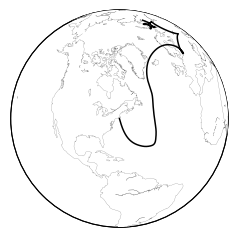

In [35]:
atmo = Atmosphere(0, RESOLUTION)
p = Parcel(atmo, lat, lon, SCHEME, 90)
tra = Trajectory(atmo, p)

tra.plot_ortho()

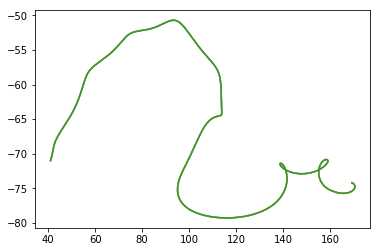